In [149]:
import requests
import bs4
import re
import pandas as pd
import json
import numpy as np
from bs4 import BeautifulSoup
file_path = 'data/'

# JSON 파일 불러오기
with open(file_path + 'PREFIX.json', 'r', encoding='utf-8') as f:
    PREFIX = json.load(f)
with open(file_path + 'SUFFIX.json', 'r', encoding='utf-8') as f:
    SUFFIX = json.load(f)


In [150]:

# 기존 구조: nested 딕셔너리 만들기
req_parameter_nested = {
    region: {
        district: PREFIX[region] + suffix[-3:]
        for district, suffix in districts.items()
    }
    for region, districts in SUFFIX.items()
}

# 평탄화(flatten) + 시단위 전체 지역 코드 추가
req_parameter = {}

for region, districts in req_parameter_nested.items():
    # 시 전체 ('서울') 코드: '강남구'처럼 직접 접근할 수 있도록
    if '전체' in districts:
        req_parameter[region] = districts['전체']  # ex) '서울': '101000'
    # 각 구/군도 추가
    for district, code in districts.items():
        req_parameter[district] = code

req_parameter2={
    '지역별':'domestic',
    '직업별':'job-category',
    '역세권별':'subway',
    'HOT100':'hot100',
    '헤드헌팅':'headhunting'
}


In [272]:
job_link_list = []
logo_list = []
title_list =[]
job_list = []
corp_list = []
local_list = []
exp_list = []
grad_list = []
date_list = []
badge_list = []
upload_list = []
for page in range(1,20):
    url = "https://www.saramin.co.kr/zf_user/jobs/list/{지역별}?page={page}&loc_cd={서울}&panel_type=&search_optional_item=n&search_done=y&panel_count=y&preview=y".format(page=page, **req_parameter2, **req_parameter)
    print(url)
    req_header = {
        'user-agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/135.0.0.0 Safari/537.36'
    }

    res = requests.get(url, headers = req_header)
    res.encoding = 'utf-8'

    
    if res.ok:
        html = res.text
        soup = BeautifulSoup(html, 'html.parser') 
        # CSS 선택자
        a_tag_list = soup.select("div#default_list_wrap div.list_body div.box_item")
        # <a> 태그 리스트 순회하기    
        for a_tag in a_tag_list:
            # 링크
            job_link_dict = {}
            if a_tag.find("div", class_ ="col company_nm").find("a", class_ = "str_tit") == None:
                job_link_dict['링크'] = 'NULL'
            else:
                job_link_dict['링크'] = "https://www.saramin.co.kr" + a_tag.find("div", class_ ="col company_nm").find("a", class_ = "str_tit")['href']
            job_link_list.append(job_link_dict)

            # 로고
            # logo_dict = {}
            # if len(a_tag.select("span.logo img[src*='banner_logo/company/logo_banner/']")) == 0:
            #     logo_dict['로고'] = 'Null'
            # else:
            #     img_url = a_tag.select("span.logo img[src*='banner_logo/company/logo_banner/']")
            #     logo_dict['로고'] = img_url[0]['src']
            # logo_list.append(logo_dict)

            # 제목
            title_dict = {}
            if len(a_tag.find("div", class_ ="col notification_info").find("div", class_ = "job_tit").select("span")) == 0:
                title_dict['제목'] = 'Null'
            else:
                title = a_tag.find("div", class_ ="col notification_info").find("div", class_ = "job_tit").select("span")[0].text
                title_dict['제목'] = title
            title_list.append(title_dict)

            # 회사
            corp_dict = {}
            if len(a_tag.find("div", class_ ="col company_nm").find(class_ = "str_tit")) == 0:
                corp_dict['회사'] = 'Null'
            else:
                corp = a_tag.find("div", class_ ="col company_nm").find(class_ = "str_tit").text
                corp_dict['회사'] = corp
            corp_list.append(corp_dict)
            clean_corp = []
            for item in corp_list:
                clean_item = {key: re.sub(r'\s+', ' ', value).strip() for key, value in item.items()}
                clean_corp.append(clean_item)
            
            # 직무
            job_dict = {}
            job = a_tag.select_one('.job_sector')
            if len(job) == 0:
                job_dict['직무'] = 'Null'
            else:
                jobs = [span.get_text(strip=True).replace('::before', '').strip() for span in job.find_all('span')]
                job_dict['직무'] = jobs
            job_list.append(job_dict)
            # 지역, 경력, 학력
            temp = a_tag.find("div", class_ = "col recruit_info")
            local_dict = {}
            exp_dict = {}
            grad_dict = {}
            if len(temp) >= 3:
                local_dict['지역'] = temp.find("p", class_ = "work_place").text
                exp_dict['요구경력'] = temp.find("p", class_ = "career").text
                grad_dict['최소학력'] = temp.find("p", class_ = "education").text
            else:
                local_dict['지역'] = 'NULL'
                exp_dict['요구경력'] = 'NULL'
                grad_dict['최소학력'] = 'NULL'
            local_list.append(local_dict)
            exp_list.append(exp_dict)
            grad_list.append(grad_dict)

            for region in local_list:
                if region['지역'].endswith(' 외'):
                    region['지역'] = region['지역'][:-2]

            # 기간
            date_dict = {}
            if len(a_tag.select("span.date")) == 0:
                date_dict['기간'] = 'Null'
            else:
                date = a_tag.select("span.date")[0].text
                date_dict['기간'] = date
            date_list.append(date_dict)

            clean_date = []
            for item in date_list:
                clean_item = {key: re.sub(r'\s+', ' ', value).strip() for key, value in item.items()}
                clean_date.append(clean_item)

            # 등록일자
            upload_dict = {}
            if len(a_tag.select_one("span.deadlines")) == 0:
                upload_dict['등록일자'] = 'Null'
            else:
                upload = a_tag.select("span.deadlines")[0].text
                upload_dict['등록일자'] = upload
            upload_list.append(upload_dict)

            # 배지
            badge_dict = {}
            if a_tag.select_one(".job_badge") == None:
                badge_dict['배지'] = 'Null'
            else:
                badge = a_tag.select_one(".job_badge").find("span").text
                badge_dict['배지'] = badge
            badge_list.append(badge_dict)
            clean_badge = []
            for item in badge_list:
                clean_item = {key: re.sub(r'\s+', ' ', value).strip() for key, value in item.items()}
                clean_badge.append(clean_item)

    else:
        # 응답(response)이 Error 이면 status code 출력    
        print(f'에러 코드 1= {res.status_code}')


https://www.saramin.co.kr/zf_user/jobs/list/domestic?page=1&loc_cd=101000&panel_type=&search_optional_item=n&search_done=y&panel_count=y&preview=y
https://www.saramin.co.kr/zf_user/jobs/list/domestic?page=2&loc_cd=101000&panel_type=&search_optional_item=n&search_done=y&panel_count=y&preview=y
https://www.saramin.co.kr/zf_user/jobs/list/domestic?page=3&loc_cd=101000&panel_type=&search_optional_item=n&search_done=y&panel_count=y&preview=y
https://www.saramin.co.kr/zf_user/jobs/list/domestic?page=4&loc_cd=101000&panel_type=&search_optional_item=n&search_done=y&panel_count=y&preview=y
https://www.saramin.co.kr/zf_user/jobs/list/domestic?page=5&loc_cd=101000&panel_type=&search_optional_item=n&search_done=y&panel_count=y&preview=y
https://www.saramin.co.kr/zf_user/jobs/list/domestic?page=6&loc_cd=101000&panel_type=&search_optional_item=n&search_done=y&panel_count=y&preview=y
https://www.saramin.co.kr/zf_user/jobs/list/domestic?page=7&loc_cd=101000&panel_type=&search_optional_item=n&search_do

In [274]:

combined_list = []
for link, title, corp, job, local, exp, grad, date, upload, badge in zip(job_link_list, title_list, clean_corp, job_list, local_list, exp_list, grad_list, clean_date, upload_list, clean_badge):
    merged_dict = {}
    merged_dict.update(link)
    merged_dict.update(title)
    merged_dict.update(corp)
    merged_dict.update(job)
    merged_dict.update(local)
    merged_dict.update(exp)
    merged_dict.update(grad)
    merged_dict.update(date)
    merged_dict.update(upload)
    merged_dict.update(badge)
    combined_list.append(merged_dict)


In [275]:

# DataFrame으로 변환
df = pd.DataFrame(combined_list)
print(job_link_list)
df

[{'링크': 'https://www.saramin.co.kr/zf_user/company-info/view-inner-recruit?csn=OXlJVG0rcW40azdacXFJYzZHQ0FxUT09'}, {'링크': 'NULL'}, {'링크': 'https://www.saramin.co.kr/zf_user/company-info/view-inner-recruit?csn=RWJPMDlGamlVMThiRGxKZFp5amNzdz09'}, {'링크': 'https://www.saramin.co.kr/zf_user/company-info/view-inner-recruit?csn=WE5wY20wYTZSMDIyeFhJTm9wN0hDdz09'}, {'링크': 'NULL'}, {'링크': 'https://www.saramin.co.kr/zf_user/company-info/view-inner-recruit?csn=TGtzTGNwdEhMbjF3NEVONThTVVR2dz09'}, {'링크': 'https://www.saramin.co.kr/zf_user/company-info/view-inner-recruit?csn=aGRLaThwcjYwbUZ4UkV3ZTU2U2JLdz09'}, {'링크': 'https://www.saramin.co.kr/zf_user/company-info/view-inner-recruit?csn=NmhFNXN3NklJZGpyem9DKy9CYjBoQT09'}, {'링크': 'https://www.saramin.co.kr/zf_user/company-info/view-inner-recruit?csn=bDhZakdSTmZkb29SMXpiL3dLelFEZz09'}, {'링크': 'https://www.saramin.co.kr/zf_user/company-info/view-inner-recruit?csn=WXNmc2pEdDViejBSYWd5U1gzRnlXdz09'}, {'링크': 'https://www.saramin.co.kr/zf_user/company-info/

,링크,제목,회사,직무,지역,요구경력,최소학력,기간,등록일자,배지
0,https://www.saramin.co.kr/zf_user/company-info...,소노그래퍼 경력 채용,(주)배럴아이,"[간호사, 방사선사, 소노그래퍼]",서울 강남구,경력 3년↑ · 정규직,대학교(4년)↑,~05.14(수),2일 전 등록,평균연봉 상위 10%
1,NULL,인하우스 디자인 / 시각 제품 그래픽 산업 3D UX UI 웹,(주)아트앤매니지먼트,"[크리에이터, 광고디자인, 그래픽디자인, 디지털디자인, 산업디자인]",서울전체,신입 · 경력 · 정규직,학력무관,~05.08(목),544일 전 등록,미디어·문화·스포츠 조회 TOP100
2,https://www.saramin.co.kr/zf_user/company-info...,(주)성풍건설 각 부문별 신입 및 경력 수시채용,(주)성풍건설,"[공무, 안전관리자, 토목기술자, 안전보건관리자, 토목설계]",충북 제천시,신입 · 경력 · 정규직,고졸↑,~05.29(목),58일 전 등록,연봉상승률 10% 이상
3,https://www.saramin.co.kr/zf_user/company-info...,[쿠팡 로지스틱스 파트너사] 소화물 배송 전담 사원 모집 공고,(주)라웰드,"[물류기사, 배송기사, 택배기사, 택시기사, 육상운송]",서울 강남구,경력무관 · 프리랜서,학력무관,~04.25(금),51일 전 등록,연봉상승률 30% 이상
4,NULL,CJ대한통운 생수 배송(서울.경기.인천.경상.광주.대전.부산.전라.충청),(주)굿앤피플컴퍼니,"[물류기사, 배송기사, 택배기사, 택시기사, 육상운송]",서울 노원구,경력무관 · 프리랜서,학력무관,~04.25(금),51일 전 등록,인기있는
...,...,...,...,...,...,...,...,...,...,...
945,https://www.saramin.co.kr/zf_user/company-info...,[화장품 데이지크] 일본 온라인MD 경력직 채용,(주)데이지크,"[기획MD, 리테일MD, 바잉MD, 브랜드MD, 영업MD]",서울전체,경력 · 정규직,학력무관,~05.09(금),9시간 전 수정,마케팅·홍보·조사 지원 급상승
946,https://www.saramin.co.kr/zf_user/company-info...,2025년 회계경리 및 총무업무,(주)로즈맘,"[경리, 세무사, 전산회계, 더존, 관리회계]",서울전체,경력 3년↑ · 정규직,고졸↑,~04.25(금),5일 전 등록,인기있는
947,https://www.saramin.co.kr/zf_user/company-info...,"건축 및 공사관리직, 총무 신입/경력 정규직 채용",일감실내건축(주),"[사무직, 총무, 사무보조, 사무행정, 건축기사]",서울 도봉구,신입 · 경력 · 정규직,고졸↑,~04.25(금),5일 전 등록,인기있는
948,https://www.saramin.co.kr/zf_user/company-info...,[대기업생산직 채용]대덕전자 전공정 신입/경력 채용,에이쓰리,"[기계조작원, 단순생산직, 생산관리, 설비OP, 외관검사원]",서울전체,경력무관 · 계약직,학력무관,~05.11(일),5일 전 등록,인기있는


In [276]:
df.replace("NULL", np.nan, inplace=True)
for i in df.columns :
    missingValueRate = df[i].isna().sum() / len(df) * 100
    if missingValueRate > 0 :
        print("{} 결측치 비율: {}%".format(i,round(missingValueRate, 2)))

링크 결측치 비율: 6.84%


In [277]:
df.shape

(950, 10)

In [278]:

df.dropna(axis = 0, inplace=True)
df.shape

(885, 10)

In [279]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

font_path = 'C:\\windows\\Fonts\\malgun.ttf'
font_prop = fm.FontProperties(fname=font_path).get_name()


matplotlib.rc('font', family=font_prop)

In [280]:
df[df['제목'].str.contains('개발', na=False)]

,링크,제목,회사,직무,지역,요구경력,최소학력,기간,등록일자,배지
70,https://www.saramin.co.kr/zf_user/company-info...,플랫폼 개발자(Vue.js) 채용,(주)나인기획,"[기술지원, 데이터분석가, 데이터엔지니어, 백엔드/서버개발, 앱개발]",서울전체,신입 · 경력 · 정규직,학력무관,D-3,9일 전 등록,인기있는
82,https://www.saramin.co.kr/zf_user/company-info...,After effects 모션그래픽 플러그인 개발자,퍼스트해빗 주식회사,"[모션그래픽, 애프터이펙트]",서울 강남구,경력무관 · 계약직,학력무관,~06.13(금),15시간 전 수정,Null
85,https://www.saramin.co.kr/zf_user/company-info...,미국 수학 콘텐츠 연구 및 개발자,퍼스트해빗 주식회사,"[교육컨텐츠개발, 교육컨텐츠기획, 수학콘텐츠연구및개발]",서울 강남구,경력 2년↑ · 정규직,대학교(4년)↑,~06.13(금),2일 전 등록,Null
118,https://www.saramin.co.kr/zf_user/company-info...,인증 서비스 서버 개발 경력직 채용,(주)신한은행,"[백엔드/서버개발, 네트워크, 솔루션, 알고리즘, API]",서울전체,경력 3년↑ · 계약직,학력무관,~04.28(월),2일 전 등록,평균연봉 상위 10%
119,https://www.saramin.co.kr/zf_user/company-info...,개발 팀장 모집(경력5~7년),(주)데이터누리,"[백엔드/서버개발, 웹개발, 프론트엔드, ECMAScript, Java]",서울전체,5 ~ 7년 · 정규직,학력무관,~05.16(금),14시간 전 등록,취업축하금
...,...,...,...,...,...,...,...,...,...,...
854,https://www.saramin.co.kr/zf_user/company-info...,국가연구개발사업 연구비 정산 업무 (계약직),(유)일신회계법인,"[회계법인, R&D, 연구행정, 연구비정산]",서울 강남구,경력 1년↑ · 계약직,"대학(2,3년)↑",~05.16(금),9일 전 등록,연구·R&D 지원 급상승
869,https://www.saramin.co.kr/zf_user/company-info...,IT 관련 교육 콘텐츠 개발 모집,(주)케이디에듀,"[HTML5, Javascript, Python, 아두이노, 교재개발]",서울전체,경력 2년↑ · 정규직,대학교(4년)↑,~04.27(일),19일 전 등록,Null
884,https://www.saramin.co.kr/zf_user/company-info...,[웹개발] 마케팅 테크기업과 성장할 웹개발자 모집,(주)에스앤지컴퍼니,"[백엔드/서버개발, 웹개발, 웹마스터, 퍼블리셔, 프론트엔드]",서울 성동구,경력무관 · 정규직,"대학(2,3년)↑",~04.30(수),14일 전 등록,IT개발·데이터 지원 급상승
892,https://www.saramin.co.kr/zf_user/company-info...,HW개발/SW개발(MacOS 부분)/안전관리 경력 채용,(주)동아엘텍,"[FPGA, H/W, MCU, RTOS, S/W]",서울전체,경력 · 정규직 외,"대학(2,3년)↑",내일마감,19일 전 등록,평균연봉 상위 10%


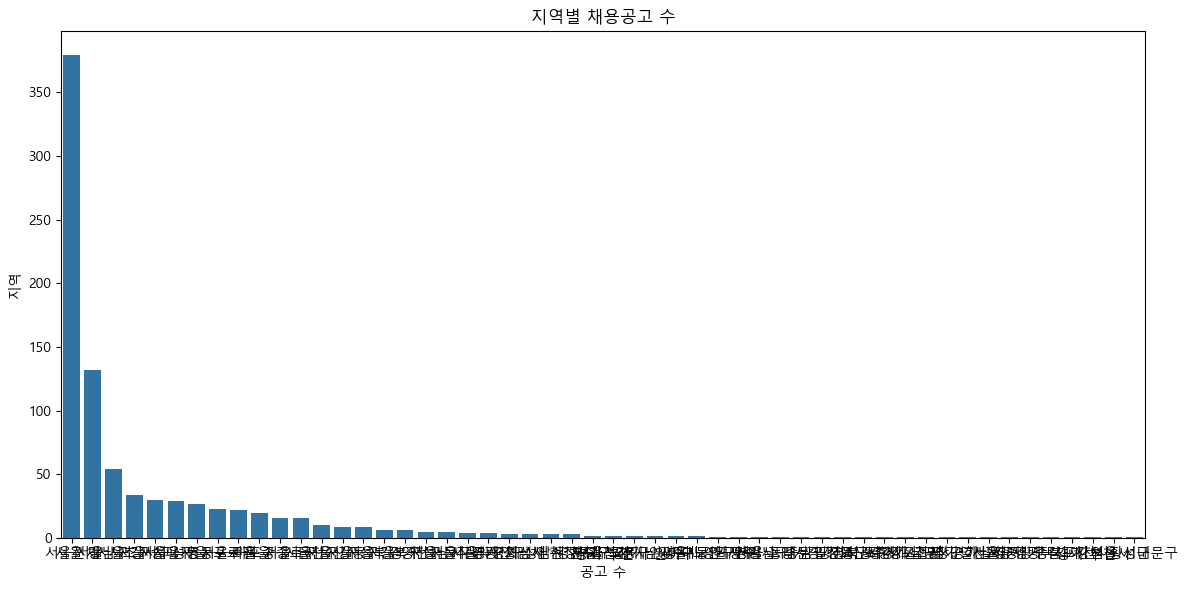

In [281]:

# 지역별 공고 수
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='지역', order=df['지역'].value_counts().index)
plt.title('지역별 채용공고 수')
plt.xlabel('공고 수')
plt.ylabel('지역')
plt.tight_layout()
plt.show()

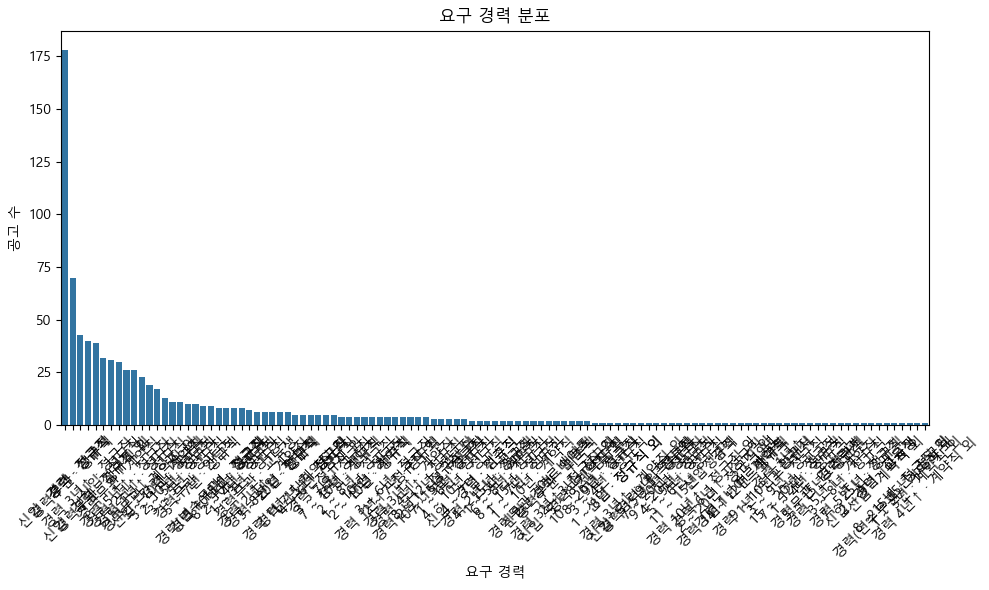

In [282]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='요구경력', order=df['요구경력'].value_counts().index)
plt.title('요구 경력 분포')
plt.xlabel('요구 경력')
plt.ylabel('공고 수')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()